# Pre explanation

This is the version where I used LeaveOneOut encoding with column ‘city’ .
And after trained the models (without oversampling and with oversampling) 
I see some of the models’ score are too high and after I checked feature importance for model 
DecisionTree, RandomForest, GB, XGB, LightGB (As their performance outperformed other models) ,
I can see ‘city’ has extremely high importance comparing to other features.
Despite of this, model Random forest and Gradient Boosting have reasonably good result after trained the model with oversampling data.
Good recall, good ROC_AUC score.
<br><b>Please read until the 57th cell, right above 'updated to this cell'</b>


# 04.04 - Modeling
+ Imports & Setup
+ Encode 'city' column via LeaveOneOutEncoder
+ Train Models with Defaul Settings
 + Select Models
 + Compare Results
+ Apply SMOTE to oversample data
+ Re-train Models Based on New Dataset (Oversampled Data)
 + Compare Results 
 + Tune Hyperparameters for Outperformed Models 
+ Choose Final Model

## Imports & Setup

In [2]:
import os
import pandas as pd
# import datetime
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
import numpy as np
# from scipy import stats
# import random
from category_encoders import LeaveOneOutEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn import model_selection

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
import xgboost as xgb
#from catboost import CatBoostClassifier
import lightgbm as lgb

import time
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_fscore_support as score, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from imblearn.over_sampling import SMOTE
%matplotlib inline

In [3]:
print(os.getcwd())
os.chdir('/Users/liuyang/Desktop/Springboard_Capstone') 
print(os.getcwd())

/Users/liuyang/Desktop/Springboard_Capstone/notebooks
/Users/liuyang/Desktop/Springboard_Capstone


In [4]:
df = pd.read_csv('data/preprocessed_train.csv')

In [5]:
df.head()

,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,city_149,0.689,1,1,0,2,1,1,2,4,1,106,0
1,city_83,0.923,1,1,0,2,1,3,1,2,1,69,0
2,city_16,0.910,1,1,0,2,1,2,1,1,1,4,0
3,city_64,0.666,1,1,0,2,1,3,1,4,1,26,0
4,city_100,0.887,1,0,0,2,1,2,1,4,1,88,1


In [6]:
df.shape

(18359, 13)

## Encode 'city' column via LeaveOneOutEncoder

In [7]:
X = df.drop(['target'],axis=1)
y = df['target']

In [8]:
# Encode column 'city'
enc = LeaveOneOutEncoder(cols=['city'])
X_enc = enc.fit_transform(X,y)
X_enc.head()

,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours
0,0.125000,0.689,1,1,0,2,1,1,2,4,1,106
1,0.099291,0.923,1,1,0,2,1,3,1,2,1,69
2,0.093164,0.910,1,1,0,2,1,2,1,1,1,4
3,0.101695,0.666,1,1,0,2,1,3,1,4,1,26
4,0.159259,0.887,1,0,0,2,1,2,1,4,1,88


In [9]:
# combine X_enc and y togehter in order to plot correlation heatmap between features and target.
df = pd.concat([X_enc,y],axis=1)

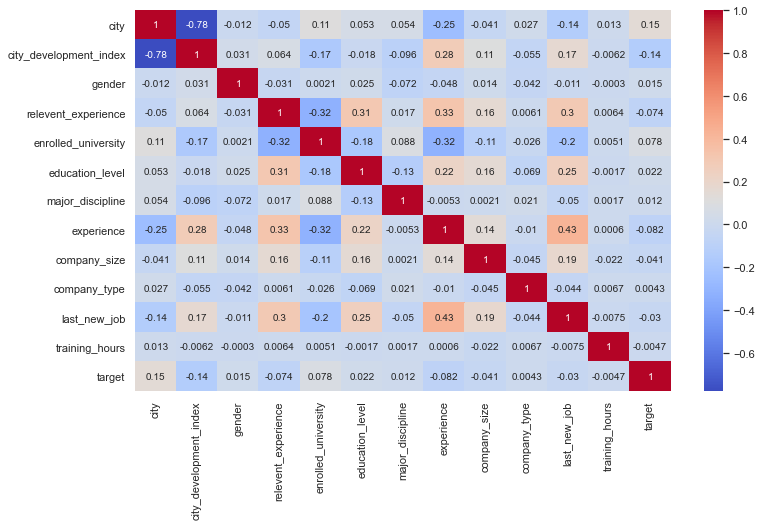

In [10]:
# plot heatmap 
_= plt.subplots(figsize=(12,7))
sns.heatmap(df.corr(),annot= True,cmap='coolwarm') 
plt.show()

In [11]:
# Define our final X by dropping 'target' and 'city'. 
X = df.drop(['target'],axis=1)
y = df['target'].ravel()


In [12]:
# Scale X 
X_scaled = StandardScaler().fit_transform(X)

In [13]:
# Split train test set
X_train,X_test,y_train,y_test = train_test_split(X_scaled, y, test_size=0.30, stratify=y, random_state=43)

In [31]:
# Confirm there's positive class in the test set.
np.unique(y_test,return_counts=True)

(array([0, 1]), array([4780,  728]))

In [32]:
# Check how imbalanced the data is in y_train.
np.unique(y_train, return_counts=True)[1][0]/np.unique(y_train, return_counts=True)[1][1]

6.572775486152033

we can see in our y_train, the ratio between negative and positive classes are 6.6 : 1 
This class imbalance may cause some negative effect when we train the model.
As our models look at the data and cleverly decide that the best thing to do is to always predict negative class and achieve high accuracy.
If that happens we will normally get high accuracy but low recall or sometimes even zero recall, precision as the model will only predict negative class.

## Train Models with Defaul Settings

### Select Models

In [17]:
index = ['LR','GNB','KNN','SVC','DT','RF','GB','XGB','LightGB']
models = [LogisticRegression(),
          GaussianNB(),
          KNeighborsClassifier(),
          SVC(probability=True, random_state=43),
          DecisionTreeClassifier(random_state=43),
          RandomForestClassifier(random_state=43),
          GradientBoostingClassifier(random_state=43),
          XGBClassifier(random_state=43),
          lgb.LGBMClassifier(objective='binary',random_state=43)]

    # combine index and models to a dictionary
model_dict = dict(zip(index,models))

In [34]:
# cv before oversampling

def model_eval(model_name, X, y, n):
    scoring = {
           'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score), 
           'f1_score' : make_scorer(f1_score),
           'roc_auc' : make_scorer(roc_auc_score, needs_proba=True)}

    kfold = KFold(n_splits=n)
    model = model_name

    model_res = model_selection.cross_validate(
                                          estimator=model,
                                          X=X,
                                          y=y,
                                          cv=kfold,
                                          scoring=scoring)
    
    return pd.DataFrame(model_res).round(3)

In [35]:
# create a function to collect all test scores for all the models before oversampling
def allmodel_perform(X, y, n):
    # create a empty list to put the average model test_score from the validation
    model_score_average = []
    
    # Loop inside the model_dict and average the test_score. (test_score contains: accuracy, precision, recall, fscore, roc_auc_score)
    # Append the avarage score to list 'model_score_average' 
    for model in model_dict.values():
        model_score_average.append(model_eval(model,X,y,n).mean())


    # put the model_score_average into a dataframe 
    df_model_eval = pd.DataFrame(model_score_average,index=list(model_dict.keys())).round(5)
    df_model_eval = df_model_eval.reset_index().rename(columns={'index':'model'})
    return df_model_eval

In [36]:
# plot test result for all models
model_res = allmodel_perform(X_train, y_train, 5)
model_res

/Users/liuyang/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liuyang/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liuyang/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liuyang/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_cl

,model,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1_score,test_roc_auc
0,LR,0.0128,0.0060,0.8678,0.0000,0.0000,0.0000,0.6404
1,GNB,0.0022,0.0052,0.8078,0.2598,0.2458,0.2524,0.6300
2,KNN,0.0792,0.3608,0.8546,0.2716,0.0598,0.0982,0.5600
3,SVC,13.7546,0.3260,0.8678,0.0000,0.0000,0.0000,0.5262
4,DT,0.0130,0.0046,0.9996,0.9982,0.9988,0.9984,0.9992
5,RF,0.5044,0.0722,0.9446,0.9960,0.5814,0.7336,0.9804
6,GB,0.5394,0.0090,0.9804,1.0000,0.8502,0.9188,0.9960
7,XGB,0.2176,0.0080,1.0000,1.0000,1.0000,1.0000,1.0000
8,LightGB,0.0984,0.0150,0.9986,0.9982,0.9918,0.9948,1.0000


In [18]:
# oversampling inside cross validation train_fold

def model_eval_os(model_name, n):
    
    precisions = []
    recalls = []
    f1scores = []
    aucs = []
    roc_aucs=[]
    y_proba = []
    y_pred = []
    
    cv = KFold(n_splits=n)
    for i, (train, test) in enumerate(cv.split(X_train, y_train)):
        X_train_fold, y_train_fold = X_train[train], y_train[train]
        X_test_fold, y_test_fold = X_train[test], y_train[test]
        
        os = SMOTE(random_state=43)
        X_train_oversampled, y_train_oversampled = os.fit_sample(X_train_fold, y_train_fold)
        model = model_name
        
        model.fit(X_train_oversampled, y_train_oversampled)
        
        y_pred = model.predict(X_test_fold)
        y_pred_proba = model.predict_proba(X_test_fold)[:,1]
        
       
        recalls.append(recall_score(y_test_fold, y_pred, pos_label=1,average='binary'))
        precisions.append(precision_score(y_test_fold, y_pred, pos_label=1,average='binary'))
        f1scores.append(f1_score(y_test_fold, y_pred, pos_label=1,average='binary'))
        roc_aucs.append(roc_auc_score(y_test_fold, y_pred_proba))
        aucs.append(model.score(X_test_fold, y_test_fold))
        y_proba.append(y_pred_proba)
    
    res = pd.DataFrame([precisions,recalls,f1scores,aucs,roc_aucs]).T
    res.columns = ['test_precison', 'test_recall', 'test_f1score', 'test_accuracy', 'test_roc_auc']
    return res
    

In [19]:
def allmodel_perform_os(n):

    model_score_average = []

    for model in model_dict.values():
        model_score_average.append(model_eval_os(model,n).mean())

    df_model_eval = pd.DataFrame(model_score_average,index=list(model_dict.keys())).round(5)
    df_model_eval = df_model_eval.reset_index().rename(columns={'index':'model'})
    return df_model_eval

In [ ]:
# plot result after oversampling inside cv train dataset
model_res_os = allmodel_perform_os(5)
model_res_os

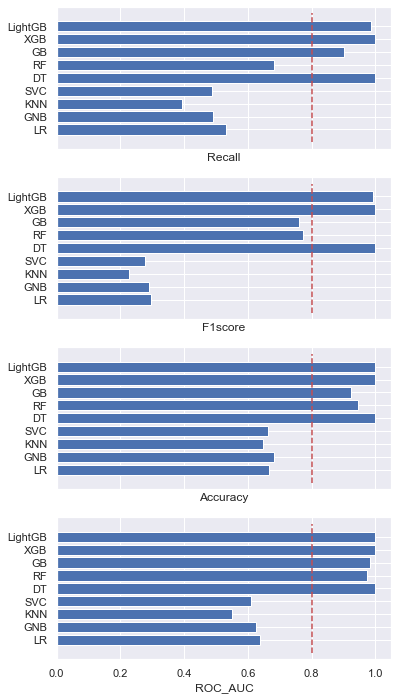

In [40]:
# plot barh plot to check the average score of recall, fscore, accuracy, roc_auc from cross validation
fig,axs = plt.subplots(4,1, figsize=(6,12),sharex=True)

axs[0].barh('model', 'test_recall', data=model_res_os)
axs[1].barh('model', 'test_f1score', data=model_res_os)
axs[2].barh('model', 'test_accuracy', data=model_res_os)
axs[3].barh('model', 'test_roc_auc',data=model_res_os)

axs[0].set_xlabel('Recall')
axs[1].set_xlabel('F1score')
axs[2].set_xlabel('Accuracy')
axs[3].set_xlabel('ROC_AUC')


axs[0].plot([0.8,0.8],[-1,9],'r--')
axs[1].plot([0.8,0.8],[-1,9],'r--')
axs[2].plot([0.8,0.8],[-1,9],'r--')
axs[3].plot([0.8,0.8],[-1,9],'r--')
plt.show()

Next, Check feature importance for model: DecisionTree, RandomForest, GB, XGB, LightGB 
As their test score outperformed the other 4 models.

<BarContainer object of 12 artists>

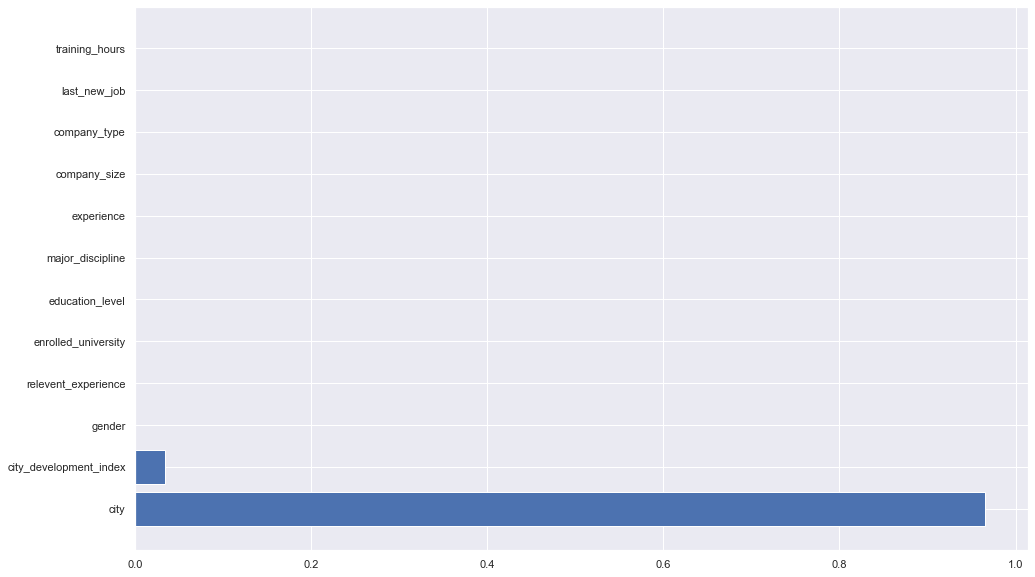

In [23]:
# feature importance for DecisionTree
model =  DecisionTreeClassifier(random_state=43)
model.fit(X_train,y_train)

fig,ax = plt.subplots(figsize=(16,10))
plt.barh(df.drop('target',axis=1).columns.tolist(), model.feature_importances_)

<BarContainer object of 12 artists>

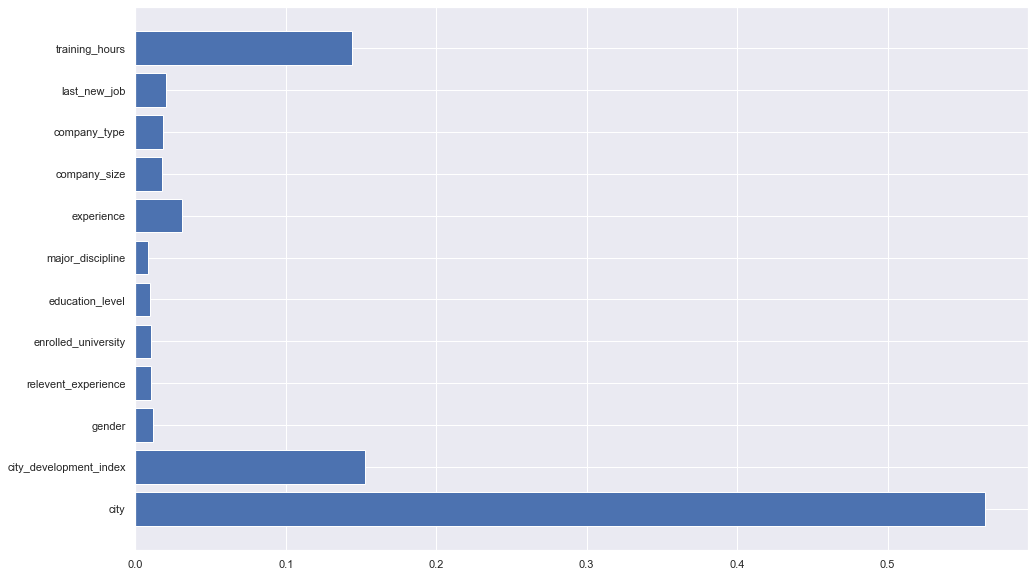

In [24]:
# feature importance for RandomForest
model = RandomForestClassifier(random_state=43)
model.fit(X_train, y_train)

fig,ax = plt.subplots(figsize=(16,10))
plt.barh(df.drop('target',axis=1).columns.tolist(), model.feature_importances_)

<BarContainer object of 12 artists>

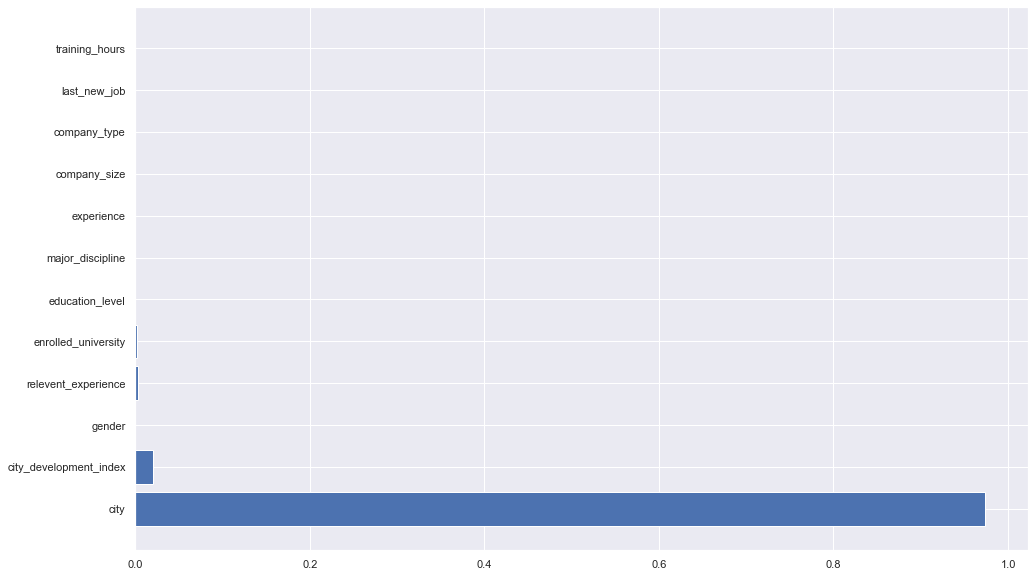

In [27]:
# feature importance for GB
model = GradientBoostingClassifier(random_state=43)
model.fit(X_train,y_train)

fig,ax = plt.subplots(figsize=(16,10))
plt.barh(df.drop('target',axis=1).columns.tolist(), model.feature_importances_)

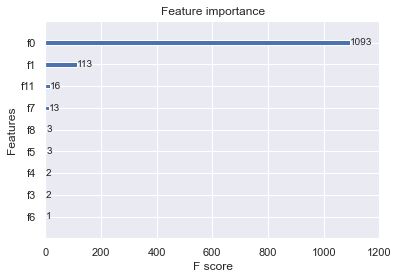

In [44]:
# feature importance for xgb
from xgboost import plot_importance
model = XGBClassifier(random_state=43)
model.fit(X_train,y_train)

plot_importance(model)
plt.show()

In [28]:
df.columns[0]

'city'

f0 is the first column in the dataset with is column 'city'

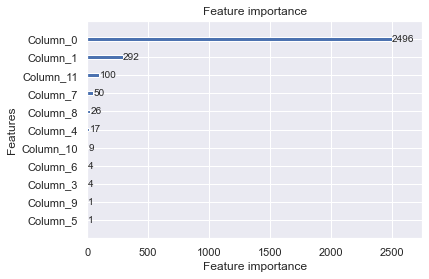

In [45]:
# # feature importance for lightgb
from lightgbm import plot_importance
model = lgb.LGBMClassifier(objective='binary',random_state=43)
model.fit(X_train,y_train)

plot_importance(model)
plt.show()

column_0 is the first column in the dataset with is column 'city'

### Check model on final test dataset with model RandomForest (before oversampling)

In [52]:
# model result before training on os data
model = RandomForestClassifier(random_state=43)
model.fit(X_train, y_train)       
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)[:,1]
precision, recall, f1score, support = score(y_test, y_pred, pos_label=1,average='binary')

print('precision:', round(precision,3), 'recall:', round(recall,3), 'f1score:', round(f1score,3))
print('roc_auc:', round(roc_auc_score(y_test, y_pred_prob),3))

precision: 0.993 recall: 0.606 f1score: 0.753
roc_auc: 0.981


### Check model on final test dataset with model RandomForest after oversampling

In [53]:
# RandomForest model result after training on os data
model = RandomForestClassifier(random_state=43)
cv = KFold(n_splits=5)


for i, (train, test) in enumerate(cv.split(X_train)):
        X_train_fold, y_train_fold = X_train[train], y_train[train]
        X_test_fold, y_test_fold = X_train[test], y_train[test]
        
        os = SMOTE(random_state=43)
        X_train_oversampled, y_train_oversampled = os.fit_sample(X_train_fold, y_train_fold)
        #model = RandomForestClassifier(random_state=43)
        
        model.fit(X_train_oversampled, y_train_oversampled)
        y_pred = model.predict(X_test_fold)
        y_pred_prob = model.predict_proba(X_test_fold)[:,1]
        #precision, recall, f1score, support = score(y_test_fold, y_pred, pos_label=1,average='binary')
       
        
yfinal = model.predict(X_test)
yfinal_proba = model.predict_proba(X_test)[:,1]
precision, recall, f1score, support = score(y_test, yfinal, pos_label=1,average='binary')

print('precision:', round(precision,3), 'recall:', round(recall,3), 'f1score:', round(f1score,3))
print('roc_auc:', round(roc_auc_score(y_test, yfinal_proba),3))

precision: 0.867 recall: 0.723 f1score: 0.788
roc_auc: 0.971


<b>recall increased from 0.606 to 0.723</b>

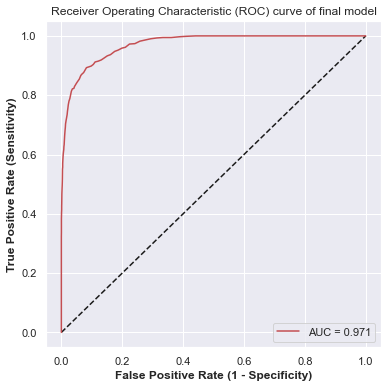

In [54]:
# RandomForest ROC_AUC result of final test dataset predicted by oversampled model

fpr,tpr,threshold = roc_curve(y_test,model.predict_proba(X_test)[:,1])
roc_auc_ = metrics.auc(fpr,tpr)
plt.figure(figsize=(6,6))
_=plt.plot([0,1],[0,1],'k--')
_=plt.plot(fpr,tpr,'r',label='AUC = %.3f'%roc_auc_)
_=plt.title('Receiver Operating Characteristic (ROC) curve of final model')
_=plt.xlabel('False Positive Rate (1 - Specificity)',fontsize=12,fontweight='bold')
_=plt.ylabel('True Positive Rate (Sensitivity)',fontsize=12,fontweight='bold')
_=plt.legend(loc='lower right')

### Check model on final test dataset with model GB (before oversampling)

In [55]:
# GB model result before training on os data
model = GradientBoostingClassifier(random_state=43)
model.fit(X_train, y_train)       
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)[:,1]
precision, recall, f1score, support = score(y_test, y_pred, pos_label=1,average='binary')

print('precision:', round(precision,3), 'recall:', round(recall,3), 'f1score:', round(f1score,3))
print('roc_auc:', round(roc_auc_score(y_test, y_pred_prob),3))

precision: 1.0 recall: 0.886 f1score: 0.94
roc_auc: 0.994


### Check model on final test dataset with model GB after oversampling

In [56]:
# GB model result after training on os data
model = GradientBoostingClassifier(random_state=43)
cv = KFold(n_splits=5)


for i, (train, test) in enumerate(cv.split(X_train)):
        X_train_fold, y_train_fold = X_train[train], y_train[train]
        X_test_fold, y_test_fold = X_train[test], y_train[test]
        
        os = SMOTE(random_state=43)
        X_train_oversampled, y_train_oversampled = os.fit_sample(X_train_fold, y_train_fold)
        #model = RandomForestClassifier(random_state=43)
        
        model.fit(X_train_oversampled, y_train_oversampled)
        y_pred = model.predict(X_test_fold)
        y_pred_prob = model.predict_proba(X_test_fold)[:,1]
        #precision, recall, f1score, support = score(y_test_fold, y_pred, pos_label=1,average='binary')
        
        
yfinal = model.predict(X_test)
yfinal_proba = model.predict_proba(X_test)[:,1]
precision, recall, f1score, support = score(y_test, yfinal, pos_label=1,average='binary')

print('precision:', round(precision,3), 'recall:', round(recall,3), 'f1score:', round(f1score,3))
print('roc_auc:', round(roc_auc_score(y_test, yfinal_proba),3))

precision: 0.648 recall: 0.92 f1score: 0.76
roc_auc: 0.986


<b>recall increased from 0.886 to 0.92</b>

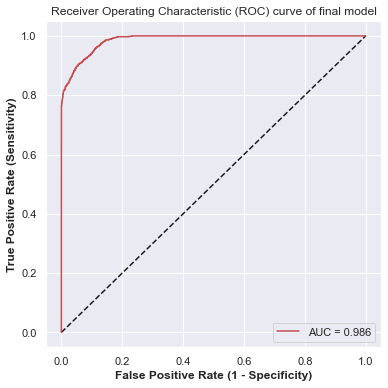

In [57]:
# GB ROC_AUC result of final test dataset predicted by oversampled model

fpr,tpr,threshold = roc_curve(y_test,model.predict_proba(X_test)[:,1])
roc_auc_ = metrics.auc(fpr,tpr)
plt.figure(figsize=(6,6))
_=plt.plot([0,1],[0,1],'k--')
_=plt.plot(fpr,tpr,'r',label='AUC = %.3f'%roc_auc_)
_=plt.title('Receiver Operating Characteristic (ROC) curve of final model')
_=plt.xlabel('False Positive Rate (1 - Specificity)',fontsize=12,fontweight='bold')
_=plt.ylabel('True Positive Rate (Sensitivity)',fontsize=12,fontweight='bold')
_=plt.legend(loc='lower right')

# updated to this cell

### Compare results

As we exolained earlier, our data is imbalanced,
so from the table above, we can see most of the models have extremely low recall as we expected.
<br>In the case of model LR and model SVC, there are no positive classes predicted.
<br>Therefore Recall, Precision, fscore are all zero.<br>We can fix this problem by either increase datas of positive classes (oversample) or decrease data of the negative classes (downsample).
<br>As our original dataset does not contain huge amout of datas, oversampling will be a better way in this case.
We will use <b>SMOTE</b> to oversample our data.

## Apply SMOTE to oversample data

We will only oversample the data from <b>X_train</b>, <b>y_train</b>. <br><b>X_test</b>, <b>y_test</b> will only be used for the final test.

In [ ]:
os = SMOTE(random_state=43)

X_os, y_os=os.fit_sample(X_train, y_train.ravel())

In [ ]:
# Check the data shape after resampleing.
print(X_os.shape)
print(y_os.shape)

In [ ]:
print(X_train.shape)
print(y_train.shape)

By oversampling we almost doubled the data points in X_train, y_train

In [ ]:
# make sure the numbers of positive and negative class are the same in the resampled data
np.unique(y_os,return_counts=True)

## Re-train Models Based on New Dataset (Oversampled Data)

In [ ]:
# Split the over sampled data: X_os, y_os to a new train_test set: X_os_train, X_os_test, y_os_train, y_os_test
X_os_train, X_os_test, y_os_train, y_os_test = train_test_split(X_os, y_os, test_size=0.3, random_state=43)

In [ ]:
# make sure the 
print(np.unique(y_os_train,return_counts=True))
print(np.unique(y_os_test,return_counts=True))

In [ ]:
# re-train models on X_os_train, y__os_train dataset with 5folds crossvalidation, and get the average test result
allmodel_perform(X_os_train, y_os_train, 5)

### Compare results

We will notice after re-training the same models based on the oversampled data (X_os_train, y_os_train) with 5folds cross validation, all the models are able to predict both classes.
Among 9 models, LightGB, XGB, GB, RF, DT overall have very good performance. (all metrics scores are higher than 0.9)

In the next step we will do two things:
<br> 1. plot five of the roc_auc test scores we got from the previous cross validation to check model variance (the less the better), 
<br> 2. plot the predicted probabily distribution to see how well the models are separating the two labels.

In [ ]:
from sklearn.metrics import plot_roc_curve
cv = KFold(n_splits=5,shuffle=True, random_state=43)

for index, model in model_dict.items():
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    y_proba = []

    fig, (ax1,ax2) = plt.subplots(1,2)
    fig.set_size_inches(16,6)
    for i, (train, test) in enumerate(cv.split(X_os_train, y_os_train)):
        model.fit(X_os_train[train], y_os_train[train])
        y_proba.append(model.predict_proba(X_os_train[test])[:,1])
        viz = plot_roc_curve(model, X_os_train[test], y_os_train[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax1)
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    ax1.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax1.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.3f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax1.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

    ax1.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic example")
    ax1.legend(loc="lower right")

    
    
    predProba_label = pd.DataFrame()
    predProba_label['proba'] = pd.DataFrame(y_proba).mean()
    predProba_label['label'] = np.array(y_os_train[test])
    predProba_label.head()
    ax2.hist(predProba_label[predProba_label.label==1].proba, density=True, histtype='step',label='Positive',color='r')
    ax2.hist(predProba_label[predProba_label.label==0].proba, density=True, histtype='step',label='Negative')
    ax2.set_xlabel('Probability of prediction', fontsize=12)
    ax2.set_ylabel('Count of observation', fontsize=12)
    ax2.legend()
    ax2.set_title('Predicted probability vs class',fontsize=12)

    plt.suptitle(("Model: %s" % index),fontsize=12,fontweight='bold')

    plt.show()

After plotting out the ROC_AUC results and the predicted probability distribution,
we can easily tell 4 models overall are outperforming other models as they generate low variance, high recall (TPR) and separate the two classes with the least overlap. 
<br>These 4 models are: Decision Tree, Random Forest, XGB and LightGB.
However DT and RF tend to overfit on training data comparing to XGB and LightGB, therefore we will focus on LightGB and XGB in the next step to optimize their hyperparameters via BayesianOptimization. 

## Tune Hyperparameters for Outperformed Models (Bayesian Optimization)

In [ ]:
from bayes_opt import BayesianOptimization

### Hyperparameter tuning for Lightgbm

In [ ]:
# # create a function to tune hyperparameters for lightGB model and get test roc_auc score
# dataset: X_os_train, y_os_train
# crossvalidation: 3

def lgb_eval(learning_rate,num_leaves, max_depth, max_bin, subsample, colsample_bytree, min_child_samples, 
             min_child_weight, min_data_in_leaf, L2, L1):
    
    params = {
        "objective" : "binary",
        "is_unbalance": True,
        "learning_rate" : learning_rate,
        "num_leaves" : int(num_leaves),
        "max_depth" : int(max_depth),
        "max_bin" : int(max_bin),
        "subsample" : subsample,
        "colsample_bytree" : colsample_bytree,
        "min_child_samples" : int(min_child_samples),
        "min_child_weight" : int(min_child_weight),
        "min_data_in_leaf" : int(min_data_in_leaf),
        "reg_lambda" : L2,
        "reg_alpha" : L1,
        "num_threads" : 20,
        "subsample_freq" : 5,
        "random_state" : 43,
        "verbose": -1
      
    }
    lgtrain = lgb.Dataset(X_os_train, y_os_train)
   
    cv_result = lgb.cv(params,
                       lgtrain,
                       num_boost_round = 1000,
                       metrics='auc',
                       early_stopping_rounds=100,
                       stratified=True,
                       nfold=3)
    
    return cv_result['auc-mean'][-1]

In [ ]:
# create a function to perform BayesianOptimization to search for the best hyperparameters
lgbBO = BayesianOptimization(lgb_eval, {'learning_rate': (0.001, 0.4),
                                        'num_leaves': (25, 4000),
                                        'max_depth': (0, 100),
                                        'max_bin': (1,1000),
                                        'subsample': (0.5, 1),
                                        'colsample_bytree': (0.4,1),
                                        'min_child_samples': (50, 10000),
                                        'min_child_weight' : (0, 0.05),
                                        'min_data_in_leaf': (10, 2000),
                                        'L2': (0.0, 100),
                                        'L1': (0.0, 1)})

lgbBO.maximize(n_iter=10, init_points=2)

In [ ]:
lgbBO.max

In [ ]:
# use model_eval function to test result of LGB model with tuned hyperparameter
# dataset: X_os_test, y_os_test with crossvalidation(5)

tuned_lgb = model_eval(lgb.LGBMClassifier
           (objective='binary', 
            L1=0.07,
            L2=97,
            colsample_bytree=0.517,
            learning_rate= 0.388,
            max_bin = 569,
            max_depth = 64,
            min_child_samples= 112,
            min_child_weight= 0.003,
            min_data_in_leaf= 58,
            num_leaves= 2876,
            subsample= 0.518,
            verbose=-1,
            random_state=43),
            X_os_test,y_os_test).mean()

tuned_lgb

In [ ]:
# test result of LGB model with default value 
# dataset: X_os_test, y_os_test with crossvalidation(5)

default_lgb = model_eval(lgb.LGBMClassifier(objective='binary',random_state=43),
                         X_os_test,y_os_test).mean()

default_lgb

### Hyperparameter tuning for XGB

In [ ]:
# create a function to tune hyperparameters for XGB model and get test roc_auc score
# dataset: X_os_train, y_os_train
# crossvalidation: 3

def XGB_eval(eta, gamma, colsample_bytree, max_depth, min_child_weight, L2):
    params = {
        "objective" : "binary:logistic",
        "eta" : eta,
        "gamma" : gamma,
        "subsample" : 0.5,
        "colsample_bytree" : colsample_bytree,
        "max_depth" : int(max_depth),
        "min_child_weight" : int(min_child_weight),
        "lambda" : L2,
        #"alpha" : L1,
        "seed" : 43,
        "nthread": 4}
    
    
    xgtrain = xgb.DMatrix(X_os_train, label=y_os_train)
    cv_result =xgb.cv(params,
                      xgtrain,
                      early_stopping_rounds=100,
                      num_boost_round=70,
                      stratified=True,
                      nfold=3,
                      metrics= 'auc')
                       
          
    return cv_result['test-auc-mean'].iloc[-1]

In [ ]:
# create a function to perform BayesianOptimization to search for the best hyperparameters
xgbBO = BayesianOptimization(XGB_eval, {'eta': (0.001,0.4),
                                        'gamma': (0,20),
                                        #'subsample': (0.5,1),
                                        'colsample_bytree': (0,1),
                                        'max_depth': (1, 10),
                                        'min_child_weight': (0,20),
                                        'L2':(0, 100)
                                        #'L1': (0, 1),
                                        })
                                        
                                        

xgbBO.maximize(n_iter=10, init_points=2)

In [ ]:
xgbBO.max

In [ ]:
# use model_eval function to test result of XGB model with tuned hyperparameter
# dataset: X_os_test, y_os_test with crossvalidation(5)

tuned_xgb = model_eval(XGBClassifier
           (#L1=0.318,
            #L2=17,
            objective='binary:logistic',
            colsample_bytree=1,
            gamma=0,
            eta= 0.4,
            max_depth = 10,
            min_child_weight=0,
            subsample=1,
            seed=43),
            X_os_test,y_os_test).mean()

tuned_xgb

In [ ]:
# test result of XGB model with default parameter values
# dataset: X_os_test, y_os_test with crossvalidation(5)

default_xgb = model_eval(XGBClassifier(
            objective='binary:logistic',
            seed=43),
            X_os_test,y_os_test).mean()

default_xgb

In [ ]:
LGB = [default_lgb[4], tuned_lgb[4], tuned_lgb[0],tuned_lgb[1]]
XGB = [default_xgb[4], tuned_xgb[4], tuned_xgb[0],tuned_xgb[1]]
comb = [LGB, XGB]

# create a dataframe to compare recall between default lgb, tune lgb, default xgb, tune xgb.
# compare fit time, score time between lgb tuned model and xgb tuned model. 
pd.DataFrame(comb, index=['LGB','XGB'], columns=['Recall_default', 'Recall_tuned', 'fit_time (tuned)', 'score_time (tuned)'])


From above we can see model LightGB and model XGB both had a small boost in Recall after we tuned the hyperparameters.
<br>Considering XGB performs slight better than LGB in terms of Recall and needs less time to predict, <br>we will choose XGB as the final model and will test it on our final test set: <b>X_test</b>, <b>y_test</b>.

## Final model

In [ ]:
# final test of XBG model with tuned hyperparameters on X_test, y_test without crossvalidation.
# dataset: X_test, y_test

final_xgb = XGBClassifier(objective='binary:logistic',
            colsample_bytree=1,
            gamma=0,
            eta= 0.4,
            max_depth = 10,
            min_child_weight=0,
            subsample=1,
            seed=43)

start = time.time()
final_xgb.fit(X_os_train,y_os_train)
end = time.time()
fit_time = end - start

start = time.time()
y_pred = final_xgb.predict(X_test)
end = time.time()
pred_time = end - start

# get precision, recall, fscore.
print(score(y_test, y_pred, pos_label=1,average='binary'))
print(fit_time)
print(pred_time)

In [ ]:
(y_pred==y_test).value_counts()

In [ ]:
# final test of LGB model with tuned hyperparameters on X_test, y_test without crossvalidation.
# dataset :X_test, y_test

final_lgb = lgb.LGBMClassifier(objective='binary', 
            L1=0.07,
            L2=97,
            colsample_bytree=0.5,
            learning_rate= 0.4,
            max_bin = 569,
            max_depth = 64,
            min_child_samples= 112,
            min_child_weight= 0.003,
            min_data_in_leaf= 58,
            num_leaves= 2876,
            subsample= 0.5,
            verbose=-1,
            random_state=43)

start = time.time()
final_lgb.fit(X_os_train,y_os_train)
end = time.time()
fit_time = end - start

start = time.time()
y_pred = final_lgb.predict(X_test)
end = time.time()

pred_time = end - start

# get precision, recall, fscore.
print(score(y_test, y_pred, pos_label=1,average='binary'))
print(fit_time)
print(pred_time)

In [ ]:
(y_pred==y_test).value_counts()

In [ ]:
## Hyperparameter tuning for RF

In [ ]:
# from sklearn.model_selection import cross_val_score

In [ ]:
# def rf_cv(X, y, **kwargs):
#     estimator = RandomForestClassifier(**kwargs)
#     cval = cross_val_score(estimator, X, y, scoring = 'roc_auc', cv = 3)
#     #cval = cross_val_score(estimator, X_train, y_train, scoring = 'roc_auc', cv = 3)
#     return cval.mean()


# def BayesianOptimization_rf(X, y):
#     def rf_crossval(n_estimators,  max_depth, 
#                     min_samples_split, max_leaf_nodes, min_samples_leaf,random_state=43):
        
#         return rf_cv(
#             X = X,
#             y = y,
#             bootstrap = True)
    
#     rfBO = BayesianOptimization(
#         f = rf_crossval,
#         pbounds = {
#             "n_estimators" : (10, 400),
#             #"max_features" : 
#             "max_depth" : (0,50),
#             "min_samples_split" : (0,5000),
#             "max_leaf_nodes" : (0,200),
#             "min_samples_leaf" : (0,0.5)
#         }
#     )
#     rfBO.maximize(n_iter = 10,init_points=2)
#     print("Final result:", rfBO.max)

In [ ]:
#BayesianOptimization_rf(X_os_train,y_os_train)

In [ ]:
# model = RandomForestClassifier(max_depth=6.24, 
#                                max_leaf_nodes=157, min_samples_leaf=0.075,
#                                min_samples_split=2216,random_state=43)

In [ ]:
## Hyperparameter tuning for LogisticRegression

In [ ]:
# def lr_cv(X, y, **kwargs):
#     estimator = LogisticRegression(**kwargs)
#     cval = cross_val_score(estimator, X, y, scoring = 'recall', cv = 3)
#     return cval.mean()


# def BayesianOptimization_lr(X, y):
#     def lr_crossval(C):
        
#         return rf_cv(
#             X = X,
#             y = y)
    
#     lrBO = BayesianOptimization(
#         f = lr_crossval,
#         pbounds = {
#             "C" : (0, 1000)
#             #"l2" : (0,100)
#         }
#     )
#     lrBO.maximize(n_iter = 10,init_points=2)
#     print("Final result:", lrBO.max)

In [ ]:
#BayesianOptimization_lr(X_os_train,y_os_train)

As we can see lightgb and xgb both perform very well, and their scores are really close.
We choose to use lightgb as the final model, as the data fit time for lgb is 8 times faster than xgb while predict times are both around less than 0.02s.

In [ ]:
fin_model =lgb.LGBMClassifier(objective='binary', 
            L1=0.214,
            L2=49,
            colsample_bytree=0.426,
            learning_rate= 0.346,
            max_depth = 10,
            min_child_samples= 4977,
            min_child_weight= 0.036,
            min_data_in_leaf= 28,
            num_leaves=49,
            subsample= 0.567,
            verbose=-1,
            random_state=43)

fin_model.fit(X_os_train, y_os_train)
fin_y_pred = fin_model.predict(X_test)

# get precision, recall, fscore
score(y_test, fin_y_pred, pos_label=1,average='binary')    

In [ ]:
lgb_fpr,lgb_tpr,threshold = roc_curve(y_test,fin_model.predict_proba(X_test)[:,1])
roc_auc_ = metrics.auc(lgb_fpr,lgb_tpr)
plt.figure(figsize=(6,6))
_=plt.plot([0,1],[0,1],'k--')
_=plt.plot(lgb_fpr,lgb_tpr,'r',label='AUC = %.3f'%roc_auc_)
_=plt.title('Receiver Operating Characteristic (ROC) curve of final model')
_=plt.xlabel('False Positive Rate (1 - Specificity)',fontsize=12,fontweight='bold')
_=plt.ylabel('True Positive Rate (Sensitivity)',fontsize=12,fontweight='bold')
_=plt.legend(loc='lower right')

#plt.savefig('figures/roc.jpg', dpi=300, bbox_inches='tight')

In [ ]:
(fin_y_pred == y_test).value_counts()

In [ ]:
metrics.confusion_matrix(y_test, y_pred,labels=[1,0])